In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

from sklearn.model_selection import KFold

np.random.seed(123)

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/DSM_processed_mono.csv")
gLV_data.head()

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
0,DSM27147-BT,0.0,0.000000,0.005000,0.000000,0.0,0.005000,0.0,0.0,0.000000
1,DSM27147-BT,12.0,0.000000,1.309089,0.000000,0.0,0.219745,0.0,0.0,0.000000
2,DSM27147-BT,24.0,0.000000,1.069737,0.000000,0.0,0.109763,0.0,0.0,0.000000
3,DSM27147-BT-BU-BV-CA,0.0,0.002000,0.002000,0.002000,0.0,0.002000,0.0,0.0,0.002000
4,DSM27147-BT-BU-BV-CA,12.0,0.010216,1.074319,0.070321,0.0,0.287990,0.0,0.0,0.119654


In [3]:
# get species names
species = list(gLV_data.columns.values[2:])

# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def test(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)
    
    # save true values and predictions
    true = []
    pred = []
    stdv = []
    spcs = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])
        
        # predict end-point measured values
        output, output_stdv, _ = model.predict_latent(x_test, tspan)
        true.append(output_true[-1])
        pred.append(output[-1, :len(species)])
        stdv.append(output_stdv[-1, :len(species)])
        spcs.append(species)
        
    return np.concatenate(true), np.concatenate(pred), np.concatenate(stdv), np.concatenate(spcs)

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 3

# input to NN includes species, resources (and maybe also time) 
n_x = n_s + n_r

# dimension of hidden layer
n_h = 8

# normalizing constant for time as input
t_max = np.max(gLV_data.Time.values)

# log of death rate 
d = -3.*np.ones(n_s)

# map to hidden dimension
p_std = 1./np.sqrt(n_x)
W1 = p_std*np.random.randn(n_h, n_x)
b1 = np.random.randn(n_h)

# maximum consumption rate parameters
C = np.zeros([n_r, n_s]) 
C[1:,:] = -3.
C[2:,:] = -5.

# parameters to compute efficiency matrix
p_std = 1./np.sqrt(n_h)
W2 = p_std*np.random.randn(n_r+n_s, n_h) 
b2 = np.random.randn(n_r+n_s)

# concatenate parameter initial guess
params = np.concatenate((d, W1.flatten(), b1, C.flatten(), W2.flatten(), b2.flatten())) #, P.flatten()))

# set prior so that C is sparse 
W1prior = np.zeros_like(W1)
b1prior = np.zeros_like(b1)
Cprior = -5.*np.ones([n_r, n_s]) 
Pprior = -5.*np.ones([n_r, n_s])
W2prior = np.zeros_like(W2)
b2prior = np.zeros_like(b2)

# concatenate prior 
prior = np.concatenate((d, W1prior.flatten(), b1prior, Cprior.flatten(), W2prior.flatten(), b2prior.flatten()))#, Pprior.flatten()))

n_params = len(params)
n_params

227

In [6]:
C.T

array([[ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.],
       [ 0., -3., -5.]])

# Define model

In [7]:
# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # compute state 
    state = jnp.concatenate((s, r))
    
    # death rate
    d = jnp.exp(params[:n_s])
    
    # map to hidden layer
    W1 = np.reshape(params[n_s:n_s+n_x*n_h], [n_h, n_x])
    b1 = params[n_s+n_x*n_h:n_s+n_x*n_h+n_h]
    h  = jnp.tanh(W1@state + b1)
    
    # maximum consumption rate parameters
    Cmax = jnp.exp(np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]))
    
    # attractiveness of resource i to species j / consumption efficiency
    W2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s:n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h], [n_r+n_s, n_h])
    b2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h:n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h+n_r+n_s], [n_r+n_s])
    f = jax.nn.sigmoid(W2@h + b2)
    
    # update Consumption matrix according to resource attractiveness 
    C = jnp.einsum("i,ij->ij", f[:n_r], Cmax)
    
    # production rate
    # P = jnp.exp(jnp.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s+(n_r+n_s)*n_h+n_r+n_s:], [n_r, n_s]))
    
    # rate of change of species 
    dsdt = s*(f[n_r:]*(C.T@r) - d)

    # rate of change of log of resources 
    dlrdt = -C@s 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [8]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

# K-fold cross-validation

In [9]:
# split dataframes according to treatment name 
mono_df = pd.concat([df for name, df in gLV_data.groupby("Treatments") if "Mono" in name])
dfs = [df for name, df in gLV_data.groupby("Treatments") if "Mono" not in name]

# set up Kfold object 
kf = KFold(n_splits = 10)

In [10]:
r0 = np.random.uniform(-3, 0, n_r)
print(r0)

# save true values, test predictions and uncertainty to a dataframe
kfold_df = pd.DataFrame()

for train_ind, test_ind in kf.split(dfs):
    
    # pull train and test data
    train_data = pd.concat([dfs[ind] for ind in train_ind])
    train_data = pd.concat([mono_df, train_data])
    
    # test data does not include mono culture
    test_data  = pd.concat([dfs[ind] for ind in test_ind])

    # fit model to training data
    model = ODE(system = system, 
                dataframe=train_data,
                C=O,
                CRparams = params, 
                r0 = r0,
                prior = prior,
                species = species,
                alpha_0 = 1e-5,
                f_ind = 1.,
                verbose=True)

    # fit to data 
    t0 = time.time()
    model.fit(evidence_tol=1e-3, patience=1, max_fails=2)
    print("Elapsed time {:.2f}s".format(time.time()-t0))
    
    # test model 
    true, pred, stdv, spcs = test(model, test_data)
    
    # save results
    fold_df = pd.DataFrame()
    fold_df['True'] = true
    fold_df['Pred'] = pred
    fold_df['Stdv'] = stdv
    fold_df['Spcs'] = spcs
    kfold_df = pd.concat((kfold_df, fold_df))

[-2.05899315 -2.85798139 -2.27494309]
Updating precision...
Total samples: 2256, Updated regularization: 1.00e-05
Total weighted fitting error: 29.016
Total weighted fitting error: 12.059
Total weighted fitting error: 9.404
Total weighted fitting error: 6.073
Total weighted fitting error: 5.696
Total weighted fitting error: 5.094
Total weighted fitting error: 4.893
Total weighted fitting error: 4.743
Total weighted fitting error: 4.639
Total weighted fitting error: 4.625
Total weighted fitting error: 4.501
Total weighted fitting error: 4.469
Total weighted fitting error: 4.333
Total weighted fitting error: 4.297
Total weighted fitting error: 4.131
Total weighted fitting error: 4.089
Total weighted fitting error: 3.887
Total weighted fitting error: 3.865
Total weighted fitting error: 3.339
Total weighted fitting error: 3.206
Total weighted fitting error: 2.960
Total weighted fitting error: 2.643
Total weighted fitting error: 2.620
Total weighted fitting error: 2.616
Total weighted fitti

Total weighted fitting error: 1082.654
Total weighted fitting error: 1081.303
Total weighted fitting error: 1079.365
Total weighted fitting error: 1079.348
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1079.3482653434064
       x: [ 1.215e+00 -2.988e+00 ... -5.382e-02 -1.099e+00]
     nit: 7
     jac: [ 1.103e+02 -4.727e-01 ...  1.698e+01  2.602e+01]
    nfev: 11
    njev: 11
    nhev: 7
Evidence 6897.725
Updating precision...
Total samples: 2256, Updated regularization: 2.51e-06
Total weighted fitting error: 1104.046
Total weighted fitting error: 1098.561
Total weighted fitting error: 1097.559
Total weighted fitting error: 1097.312
Total weighted fitting error: 1097.191
Total weighted fitting error: 1094.538
Total weighted fitting error: 1094.276
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1094.2763598055174
       x: [ 1.251e+00 -2.975e+00 ... -6.090e-02 -1.104e+00]
     nit: 7
     jac: [-9.421e+02 -1.11

Evidence 6710.680
Updating precision...
Total samples: 2256, Updated regularization: 6.22e-06
Total weighted fitting error: 1097.193
Total weighted fitting error: 1087.778
Total weighted fitting error: 1087.734
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1087.7336597836136
       x: [ 1.344e+00 -2.917e+00 ...  2.069e-01 -3.269e-01]
     nit: 3
     jac: [ 8.022e+01  7.787e+00 ...  1.713e+00  5.407e+00]
    nfev: 7
    njev: 7
    nhev: 3
Evidence 6733.223
Updating precision...
Total samples: 2256, Updated regularization: 7.37e-06
Total weighted fitting error: 1095.870
Total weighted fitting error: 1095.367
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1095.3670085727442
       x: [ 1.365e+00 -2.915e+00 ...  2.060e-01 -3.541e-01]
     nit: 2
     jac: [ 2.704e+02  1.658e+01 ... -4.245e+01 -4.450e+01]
    nfev: 4
    njev: 4
    nhev: 2
Evidence 6748.961
Updating precision...
Total samples: 2256, Updated regu

Hessian not positive definite, increasing regularization...
Evidence 5345.362
Updating precision...
Total samples: 2256, Updated regularization: 9.12e-07
Total weighted fitting error: 718.621
Total weighted fitting error: 717.108
Total weighted fitting error: 714.171
Total weighted fitting error: 714.096
Total weighted fitting error: 711.088
Total weighted fitting error: 710.977
Total weighted fitting error: 706.959
Total weighted fitting error: 706.486
Total weighted fitting error: 706.024
Total weighted fitting error: 701.867
Total weighted fitting error: 701.458
Total weighted fitting error: 701.329
Total weighted fitting error: 696.957
Total weighted fitting error: 696.072
Total weighted fitting error: 696.013
Total weighted fitting error: 693.639
Total weighted fitting error: 693.602
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 693.6016289775396
       x: [ 1.086e+00 -2.728e+00 ... -3.198e-01 -7.454e-01]
     nit: 17
     jac: [ 6.702e+00  2

Hessian not positive definite, increasing regularization...
Evidence 2834.000
Updating precision...
Total samples: 2256, Updated regularization: 8.59e-07
Total weighted fitting error: 243.725
Total weighted fitting error: 236.381
Total weighted fitting error: 235.965
Total weighted fitting error: 235.743
Total weighted fitting error: 233.713
Total weighted fitting error: 233.698
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 233.69794466046673
       x: [ 1.262e+00 -2.985e+00 ...  7.022e-01 -4.944e-01]
     nit: 6
     jac: [ 2.259e+01  1.472e+00 ... -7.378e-01  9.253e+00]
    nfev: 9
    njev: 9
    nhev: 6
Hessian not positive definite, increasing regularization...
Evidence 5471.318
Updating precision...
Total samples: 2256, Updated regularization: 7.01e-07
Total weighted fitting error: 794.374
Total weighted fitting error: 793.978
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 793.9775487324465
       x: [ 1

Total weighted fitting error: 20.147
Total weighted fitting error: 20.106
Total weighted fitting error: 19.782
Total weighted fitting error: 19.746
Total weighted fitting error: 19.732
Total weighted fitting error: 19.709
Total weighted fitting error: 19.533
Total weighted fitting error: 19.500
Total weighted fitting error: 19.489
Total weighted fitting error: 19.485
Total weighted fitting error: 19.309
Total weighted fitting error: 19.290
Total weighted fitting error: 19.285
Total weighted fitting error: 19.275
Total weighted fitting error: 19.071
Total weighted fitting error: 19.010
Total weighted fitting error: 18.941
Total weighted fitting error: 18.918
Total weighted fitting error: 18.890
Total weighted fitting error: 18.752
Total weighted fitting error: 18.742
Total weighted fitting error: 18.725
Total weighted fitting error: 18.609
Total weighted fitting error: 18.576
Total weighted fitting error: 18.569
Total weighted fitting error: 18.566
Total weighted fitting error: 18.464
T

Total weighted fitting error: 1.807
Total weighted fitting error: 1.777
Total weighted fitting error: 1.759
Total weighted fitting error: 1.753
Total weighted fitting error: 1.747
Total weighted fitting error: 1.706
Total weighted fitting error: 1.698
Total weighted fitting error: 1.693
Total weighted fitting error: 1.690
Total weighted fitting error: 1.652
Total weighted fitting error: 1.651
Total weighted fitting error: 1.649
Total weighted fitting error: 1.630
Total weighted fitting error: 1.628
Total weighted fitting error: 1.591
Total weighted fitting error: 1.589
Total weighted fitting error: 1.585
Total weighted fitting error: 1.581
Total weighted fitting error: 1.551
Total weighted fitting error: 1.549
Total weighted fitting error: 1.548
Total weighted fitting error: 1.524
Total weighted fitting error: 1.522
Total weighted fitting error: 1.518
Total weighted fitting error: 1.486
Total weighted fitting error: 1.482
Total weighted fitting error: 1.480
Total weighted fitting error

Total weighted fitting error: 1108.069
Total weighted fitting error: 1107.914
Total weighted fitting error: 1106.677
Total weighted fitting error: 1106.450
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 1106.450284151389
       x: [ 1.060e+00 -2.518e+00 ...  2.481e-01 -4.571e-01]
     nit: 5
     jac: [ 6.639e+01  1.153e+00 ... -7.437e-01  1.218e+01]
    nfev: 10
    njev: 10
    nhev: 5
Evidence 6824.088
Pass count  1
Elapsed time 536.59s
Updating precision...
Total samples: 2256, Updated regularization: 1.00e-05
Total weighted fitting error: 29.393
Total weighted fitting error: 11.900
Total weighted fitting error: 7.882
Total weighted fitting error: 7.336
Total weighted fitting error: 6.366
Total weighted fitting error: 4.980
Total weighted fitting error: 4.693
Total weighted fitting error: 4.532
Total weighted fitting error: 4.456
Total weighted fitting error: 4.446
Total weighted fitting error: 4.346
Total weighted fitting error: 4.257
Total we

Total weighted fitting error: 939.398
Total weighted fitting error: 928.458
Total weighted fitting error: 926.689
Total weighted fitting error: 926.493
Total weighted fitting error: 926.213
Total weighted fitting error: 919.372
Total weighted fitting error: 916.975
Total weighted fitting error: 915.727
Total weighted fitting error: 914.954
Total weighted fitting error: 907.663
Total weighted fitting error: 907.360
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 907.3598700132077
       x: [ 1.215e+00 -1.090e+00 ...  3.866e-01 -7.770e-01]
     nit: 56
     jac: [ 5.936e+02  1.019e+02 ...  3.289e+01  2.292e+02]
    nfev: 92
    njev: 92
    nhev: 56
Hessian not positive definite, increasing regularization...
Evidence 6949.970
Updating precision...
Total samples: 2256, Updated regularization: 5.22e-06
Total weighted fitting error: 1062.229
Total weighted fitting error: 1058.288
Total weighted fitting error: 1057.422
Total weighted fitting error: 1056.4

Total weighted fitting error: 20.579
Total weighted fitting error: 20.570
Total weighted fitting error: 20.568
Total weighted fitting error: 20.332
Total weighted fitting error: 20.279
Total weighted fitting error: 20.254
Total weighted fitting error: 20.247
Total weighted fitting error: 20.194
Total weighted fitting error: 20.194
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 20.19402961682249
       x: [ 1.234e+00 -2.934e+00 ... -3.383e-01 -3.867e-01]
     nit: 23
     jac: [ 8.978e-02  2.795e-02 ... -1.018e-01  4.357e-01]
    nfev: 36
    njev: 36
    nhev: 23
Hessian not positive definite, increasing regularization...
Evidence 2749.150
Updating precision...
Total samples: 2256, Updated regularization: 8.08e-07
Total weighted fitting error: 221.557
Total weighted fitting error: 219.112
Total weighted fitting error: 218.987
Total weighted fitting error: 218.895
Total weighted fitting error: 218.021
Total weighted fitting error: 218.011
Total weig

Total weighted fitting error: 1.744
Total weighted fitting error: 1.743
Total weighted fitting error: 1.742
Total weighted fitting error: 1.707
Total weighted fitting error: 1.700
Total weighted fitting error: 1.695
Total weighted fitting error: 1.662
Total weighted fitting error: 1.657
Total weighted fitting error: 1.651
Total weighted fitting error: 1.642
Total weighted fitting error: 1.639
Total weighted fitting error: 1.597
Total weighted fitting error: 1.588
Total weighted fitting error: 1.586
Total weighted fitting error: 1.570
Total weighted fitting error: 1.567
Total weighted fitting error: 1.566
Total weighted fitting error: 1.557
Total weighted fitting error: 1.555
Total weighted fitting error: 1.533
Total weighted fitting error: 1.529
Total weighted fitting error: 1.528
Total weighted fitting error: 1.509
Total weighted fitting error: 1.507
Total weighted fitting error: 1.505
Total weighted fitting error: 1.484
Total weighted fitting error: 1.482
Total weighted fitting error

Total weighted fitting error: 2.419
Total weighted fitting error: 2.315
Total weighted fitting error: 2.309
Total weighted fitting error: 2.304
Total weighted fitting error: 2.256
Total weighted fitting error: 2.255
Total weighted fitting error: 2.226
Total weighted fitting error: 2.219
Total weighted fitting error: 2.164
Total weighted fitting error: 2.149
Total weighted fitting error: 2.137
Total weighted fitting error: 2.113
Total weighted fitting error: 2.112
Total weighted fitting error: 2.083
Total weighted fitting error: 2.080
Total weighted fitting error: 2.003
Total weighted fitting error: 1.986
Total weighted fitting error: 1.977
Total weighted fitting error: 1.911
Total weighted fitting error: 1.903
Total weighted fitting error: 1.857
Total weighted fitting error: 1.842
Total weighted fitting error: 1.837
Total weighted fitting error: 1.835
Total weighted fitting error: 1.773
Total weighted fitting error: 1.761
Total weighted fitting error: 1.756
Total weighted fitting error

Evidence 6876.613
Pass count  1
Elapsed time 439.19s


In [14]:
kfold_df.to_csv("kfold/CRNN_kfold_cdiff.csv", index=False)

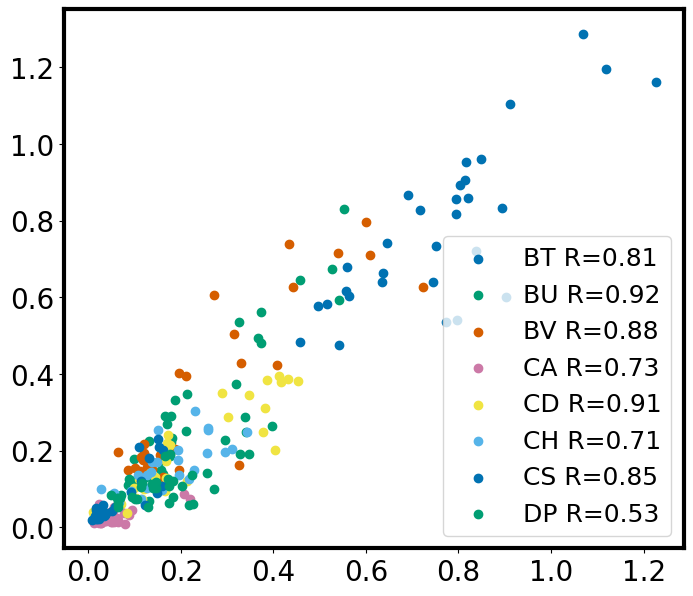

In [15]:
true = kfold_df['True'].values
pred = kfold_df['Pred'].values
stdv = kfold_df['Stdv'].values
spcs = kfold_df['Spcs'].values

for i,sp in enumerate(np.unique(spcs)):
    sp_inds = spcs == sp
    inds_pos = true[sp_inds] > 0
    
    R = linregress(true[sp_inds][inds_pos], pred[sp_inds][inds_pos]).rvalue
    plt.scatter(true[sp_inds][inds_pos], pred[sp_inds][inds_pos], c=f"C{i}", label=sp + " R={:.2f}".format(R))
plt.legend(loc="lower right")
plt.savefig("kfold/CRNN_kfold.pdf")
plt.show()